In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pathlib
from typing import List, Tuple
import uproot3
import struct

In [2]:
ls ~/data/2D_recovery_studies/increased_covmatrix

old/  xyz_seq/  xyz_seq_histat/


In [3]:
input_file = (
    str(pathlib.Path.home())
    + '/data/2D_recovery_studies/increased_covmatrix/xyz_seq/Lb2JPsiL_Run2_Sim_2016_MagUp_v12_with2D.root'
)

In [4]:
save_plots = True

## Pick what extra branches you want
with_dtf = True
with_pidsubs = False
with_protoparticles = True
with_2Ddebug = True
with_truevtx_kinematics = True

## Perform analysis with:
## - All data: 'b' (both)
## - Only Lambdas: 'm' (matter)
## - Only antiLambdas: 'a' (antimatter)
use_matter_antimatter = 'm'

## Choose colors
color_gen = 'tab:gray'
color_3D = 'tab:blue'
color_2D = 'tab:orange'

truth_match = False ## Failed attempt at truth matching, not needed

In [5]:
if use_matter_antimatter == 'b':
    event_category_label = 'All reconstructed events'
elif use_matter_antimatter == 'm':
    event_category_label = 'Only matter events'
elif use_matter_antimatter == 'a':
    event_category_label = 'Only antimatter events'
else:
    raise ValueError

In [6]:
## Create plots directory, if missing
plots_dir = (str(pathlib.Path.home())
                  + '/vertex-reconstruction-studies/'
                  + 'plots/'
                  + 'studies_on_integrated_root_files/'
                  + 'residuals_at_first_measurement_analysis/'
)
pathlib.Path(plots_dir).mkdir(parents=True, exist_ok=True)

# Import data (v2.1)

In [1]:
def root_file_to_df(
    filename: str,
    branches_ordinary: List[str] = [],
    branches_jagged: List[str] = [],   ## These are the protoparticles, really
    truth_tree: bool = False,
    slice_ordinary: bool = True
) -> pd.DataFrame:
    if len(branches_jagged) == 0:
        have_jagged = False
    else:
        have_jagged = True
    
    if len(branches_ordinary) == 0:
        have_ordinary = False
    else:
        have_ordinary = True
    
    with uproot3.open(filename) as file_root:
        if truth_tree:
            tree = file_root['Lb_MC/MCDecayTree']
        else:
            tree = file_root['Lb_T/DecayTree']
        ## Load dataFrame with desired branches
        if have_ordinary:
            if slice_ordinary:
                df_ord = tree.pandas.df(branches_ordinary).loc[(slice(None), 0), :]
            else:
                df_ord = tree.pandas.df(branches_ordinary)
        if have_jagged:
            df_jag = tree.pandas.df(branches_jagged, flatten=False)
            for col in list(df_jag):
                df_jag[col] = df_jag[col].str[0]
        
        if have_ordinary and not have_jagged:
            df = df_ord
        elif not have_ordinary and have_jagged:
            df = df_jag
        elif have_ordinary and have_jagged:
            df = pd.merge(df_ord, df_jag, left_index=True, right_index=True)
            if len(df) != len(df_jag):
                raise ValueError
        else:
            raise ValueError
            
        ## Reset indices
        df.reset_index(drop=True, inplace=True)
        return df

NameError: name 'List' is not defined

## Reco

### Choose branches

In [8]:
composite_particles = ['Lb', 'L', 'Jpsi']
basic_particles = ['p', 'pim', 'mum', 'mup']
lambda_baryons = ['L', 'Lb']

lambdab_daughters = ['L', 'Jpsi']
lambdab_daughters_DTF = ['Lambda0', 'J_psi_1S']

lambdab_nephews = {
    'L': ['p', 'pim'],
    'Jpsi': ['mum', 'mup'],
}
lambdab_nephews_DTF = {
    'Lambda0': ['pplus', 'piplus'],
    'J_psi_1S': ['muminus_0', 'muminus'],
}

DTF_mass_constraints = ['FixJPsi', 'FixJPsiLambda']

#### Original names

In [9]:
## Reco branches
reco_branches = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_ENDVERTEX_' + component)
    reco_branches.append(prefix + '_M')
    reco_branches.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_P' + component)
    reco_branches.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches.append(prefix + '_BPVDIRA')
    reco_branches.append(prefix + '_BPVIPCHI2')
    reco_branches.append(prefix + '_BPVVDCHI2')
    reco_branches.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches.append('Lb_OWNPV_' + feature)

reco_branches.append('Polarity')

## Truth branches
truth_branches = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEP_' + component)

truth_branches.append('L_TRUEID')
truth_branches.append('Lb_TRUEID')
        
for prefix in basic_particles + composite_particles:
    truth_branches.append(prefix + '_Reconstructible')
    truth_branches.append(prefix + '_Reconstructed')

## DTF branches
dtf_branches = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_status')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_M')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_P')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_chi2')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_M')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_P')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_' + daughter + '_P' + component)
                    
    pidsubs_branches.append('TrackType')

## Protoparticle branches
pp_branches = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches = []
if with_2Ddebug:
    debug_branches.append('L_ENDVERTEX_XERR')
    debug_branches.append('L_ENDVERTEX_YERR')
    debug_branches.append('L_ENDVERTEX_ZERR')
    debug_branches.append('L_ALGO_ID')
    
## True vertex kinematics
truevtxkin_branches = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
                
    for prefix in ['p', 'pim']:
        ## Actually no need for z, it's fixed by the transporter
        for component in ['X', 'Y', 'Z']:
            truevtxkin_branches.append('MCTRUTH_' + prefix + '_AtFirstMeas_REFP_' + component)
            truevtxkin_branches.append('MCTRUTH_' + prefix + '_AtFirstMeas_REFP_' + component + "ERR")

        for component in ['X', 'Y', 'Z']:
            truevtxkin_branches.append('MCTRUTH_' + prefix + '_AtFirstMeas_P_' + component)
            truevtxkin_branches.append('MCTRUTH_' + prefix + '_AtFirstMeas_P_' + component + "ERR")
    
branches = (
    reco_branches + truth_branches
    + dtf_branches + pidsubs_branches
    + debug_branches + truevtxkin_branches
)

branches_jagged = pp_branches

#### New names

In [10]:
## Reco branches
reco_branches_renamed = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_ENDVERTEX_' + component)
    reco_branches_renamed.append(prefix + '_M')
    reco_branches_renamed.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_P' + component)
    reco_branches_renamed.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches_renamed.append(prefix + '_BPVDIRA')
    reco_branches_renamed.append(prefix + '_BPVIPCHI2')
    reco_branches_renamed.append(prefix + '_BPVVDCHI2')
    reco_branches_renamed.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches_renamed.append('Lb_OWNPV_' + feature)

reco_branches_renamed.append('Polarity')

## Truth branches
truth_branches_renamed = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_ENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_P' + component)

truth_branches_renamed.append('MCTRUTH_L_ID')
truth_branches_renamed.append('MCTRUTH_Lb_ID')
        
for prefix in basic_particles + composite_particles:
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructible')
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructed')

## DTF branches
dtf_branches_renamed = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_status')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_M')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_P')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_chi2')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches_renamed.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters:
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches_renamed = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_M')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_P')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + daughter + '_P' + component)
                    
    pidsubs_branches_renamed.append('TrackType')

## Protoparticle branches
pp_branches_renamed = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches_renamed.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches_renamed.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches_renamed = []
if with_2Ddebug:
    debug_branches_renamed.append('L_ENDVERTEX_XERR')
    debug_branches_renamed.append('L_ENDVERTEX_YERR')
    debug_branches_renamed.append('L_ENDVERTEX_ZERR')
    debug_branches_renamed.append('L_ALGO_ID')

## True vertex kinematics
truevtxkin_branches_renamed = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
                
    for prefix in ['p', 'pim']:
        ## Actually no need for z, it's fixed by the transporter
        for component in ['X', 'Y', 'Z']:
            truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_AtFirstMeas_REFP_' + component)
            truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_AtFirstMeas_REFP_' + component + "ERR")

        for component in ['X', 'Y', 'Z']:
            truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_AtFirstMeas_P_' + component)
            truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_AtFirstMeas_P_' + component + "ERR")
                
branches_renamed = (
    reco_branches_renamed + truth_branches_renamed
    + dtf_branches_renamed + pidsubs_branches_renamed
    + debug_branches_renamed + truevtxkin_branches_renamed
)

branches_jagged_renamed = pp_branches_renamed

In [11]:
if len(branches_renamed) != len(branches):
    raise ValueError("Number of ordinary columns before and after renaming does not match.")
    
if len(branches_jagged_renamed) != len(branches_jagged):
    raise ValueError("Number of jagged columns before and after renaming does not match.")

### Import ROOT file

In [12]:
df_reco = root_file_to_df(input_file, branches, branches_jagged)

column_rename_dictionary = {}
for old_name, new_name in zip(branches, branches_renamed):
    column_rename_dictionary[old_name] = new_name
for old_name, new_name in zip(branches_jagged, branches_jagged_renamed):
    column_rename_dictionary[old_name] = new_name
    
df_reco.rename(columns=column_rename_dictionary, inplace=True)

### Replace `ALGO_ID` with intelligible labels

In [13]:
algo_id_dictionary = {
    -10: 'NonConverged',
     -1: 'Unspecified',
      0: 'VertexFitter',
      1: 'XBlownUpAlgorithm',
      2: 'YBlownUpAlgorithm',
      3: 'XYBlownUpAlgorithm',
      4: 'ZBlownUpAlgorithm',
      5: 'XZBlownUpAlgorithm',
      6: 'YZBlownUpAlgorithm',
      7: 'XYZBlownUpAlgorithm',
     10: 'Generic2DAlgorithm',
}

df_reco.replace({'L_ALGO_ID': algo_id_dictionary}, inplace=True)

## Truth

In [14]:
if truth_match:
    truth_match_branches = []
    for part in ['Lb', 'L']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches.append(part + '_TRUEENDVERTEX_' + comp)

    for part in ['p', 'pim', 'mum', 'mup']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches.append(part + '_TRUEP_' + comp)
        
        truth_match_branches.append(part + '_Reconstructible')
        truth_match_branches.append(part + '_Reconstructed')

    truth_pp_branches = []
    if with_protoparticles:
        for part in ['p', 'pim']:
            for feature in ['', 'P']:
                for comp in ['X', 'Y', 'Z']:
                    truth_pp_branches.append(part + '_PP_' + feature + comp)

            #pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros

            #for row in pmc_components:
            #    for column in [c for c in pmc_components if c >= row]:
            #        truth_pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))

    truth_tree_branches_ordinary = truth_match_branches
    truth_tree_branches_jagged = truth_pp_branches

In [15]:
if truth_match:
    truth_match_branches_renamed = []
    for part in ['Lb', 'L']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches_renamed.append('MCTRUTH_' + part + '_ENDVERTEX_' + comp)

    for part in ['p', 'pim', 'mum', 'mup']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches_renamed.append('MCTRUTH_' + part + '_P' + comp)

        truth_match_branches_renamed.append('MCTRUTH_' + part + '_Reconstructible')
        truth_match_branches_renamed.append('MCTRUTH_' + part + '_Reconstructed')
            
    truth_pp_branches_renamed = []
    if with_protoparticles:
        for part in ['p', 'pim']:
            for feature in ['', 'P']:
                for comp in ['X', 'Y', 'Z']:
                    truth_pp_branches_renamed.append('MCTRUTH_' + part + '_PP_' + feature + comp)

            #pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros

            #for row in pmc_components:
            #    for column in [c for c in pmc_components if c >= row]:
            #        truth_pp_branches_renamed.append('MCTRUTH_' + part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))

    truth_tree_branches_ordinary_renamed = truth_match_branches_renamed
    truth_tree_branches_jagged_renamed = truth_pp_branches_renamed

In [16]:
if truth_match:
    if len(truth_tree_branches_ordinary) != len(truth_tree_branches_ordinary_renamed):
        raise ValueError("Number of ordinary columns before and after renaming does not match.")

    if len(truth_tree_branches_jagged) != len(truth_tree_branches_jagged_renamed):
        raise ValueError("Number of ordinary columns before and after renaming does not match.")

In [17]:
if truth_match:
    df_truth = root_file_to_df(input_file,
                               branches_ordinary=truth_tree_branches_ordinary,
                               branches_jagged=truth_tree_branches_jagged,
                               truth_tree=True,
                               slice_ordinary=False)

    column_rename_dictionary = {}
    for old_name, new_name in zip(truth_tree_branches_jagged, truth_tree_branches_jagged_renamed):
        column_rename_dictionary[old_name] = new_name

    for old_name, new_name in zip(truth_tree_branches_ordinary, truth_tree_branches_ordinary_renamed):
        column_rename_dictionary[old_name] = new_name

    df_truth.rename(columns=column_rename_dictionary, inplace=True)
    df_truth

## Merge truth and reco
This includes "truth matching", i.e. taking out whatever isn't signal.

In [18]:
if truth_match:
    columns_for_long_key = [
        'MCTRUTH_Lb_ENDVERTEX_X',
        'MCTRUTH_Lb_ENDVERTEX_Y',
        'MCTRUTH_Lb_ENDVERTEX_Z',
        'MCTRUTH_L_ENDVERTEX_X',
        'MCTRUTH_L_ENDVERTEX_Y',
        'MCTRUTH_L_ENDVERTEX_Z',
        'MCTRUTH_p_PX',
        'MCTRUTH_p_PY',
        'MCTRUTH_p_PZ',
        'MCTRUTH_pim_PX',
        'MCTRUTH_pim_PY',
        'MCTRUTH_pim_PZ',
        'MCTRUTH_mum_PX',
        'MCTRUTH_mum_PY',
        'MCTRUTH_mum_PZ',
        'MCTRUTH_mup_PX',
        'MCTRUTH_mup_PY',
        'MCTRUTH_mup_PZ',
    ]

In [19]:
if truth_match:
    df_reco['MC_longkey'] = df_reco.loc[:, columns_for_long_key].agg(lambda x : struct.pack('f' * len(columns_for_long_key), *x), axis='columns')
    df_truth['MC_longkey'] = df_reco.loc[:, columns_for_long_key].agg(lambda x : struct.pack('f' * len(columns_for_long_key), *x), axis='columns')
    
    df_truth.drop(columns=columns_for_long_key, inplace=True)
    
    df_truth['MC_key'] = df_truth.index
    df_reco['Rec_key'] = df_reco.index
    
    df_reco = pd.merge(df_reco, df_truth.loc[:, ['MC_longkey', 'MC_key']], on='MC_longkey', how='left')
    
    df_reco['TrackType'] = 'T'
    
    df_MC_grouped = df_reco.loc[:, ['MC_longkey', 'Rec_key', 'TrackType']].groupby('MC_longkey').agg({'Rec_key' : ['min', 'count'], 'TrackType' : ['first']}).reset_index()
    df_MC_grouped.columns = ['MC_longkey', 'Rec_key', 'N_rec_matches', 'TrackType']
    df_truth = pd.merge(df_truth, df_MC_grouped, on='MC_longkey', how='left')
    df_truth['TrackType'] = df_truth['TrackType'].fillna('NA').astype(dtype='category')

    df_reco.drop('MC_longkey', inplace=True, axis='columns')
    df_truth.drop('MC_longkey', inplace=True, axis='columns')
    
    df_reco.index.name = 'Rec_key'
    df_reco.drop('Rec_key', inplace=True, axis='columns')
    df_truth.index.name = 'MC_key'
    df_truth.drop('MC_key', inplace=True, axis='columns')

    # Downcasting the keys and counters
    df_reco['MC_key'] = pd.to_numeric(df_reco['MC_key'].fillna(-1), downcast='signed')
    df_truth['Rec_key'] = pd.to_numeric(df_truth['Rec_key'].fillna(-1), downcast='signed')
    df_truth['N_rec_matches'] = pd.to_numeric(df_truth['N_rec_matches'].fillna(0), downcast='unsigned')

In [20]:
if truth_match:
    df_events = pd.merge(df_truth, df_reco.loc[df_reco['MC_key'] >= 0, :].drop('TrackType', axis='columns').groupby('MC_key').first(), how='left', on='MC_key')

## If we don't want the truth info...
(And we don't, because PP information is absolutely unreliable.)

In [21]:
if not truth_match:
    df_events = df_reco
    del(df_reco)

# Apply further selections
## Select matter/antimatter

In [22]:
if not use_matter_antimatter == 'b':
    if use_matter_antimatter == 'm':
        Lb_ID_constraint = 5122
    elif use_matter_antimatter == 'a':
        Lb_ID_constraint = -5122
    else:
        raise ValueError
    
    df_events = df_events.loc[df_events['MCTRUTH_Lb_ID'] == Lb_ID_constraint]

In [23]:
df_events

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,pim_PP_POSMOMCOV_1_1,pim_PP_POSMOMCOV_1_3,pim_PP_POSMOMCOV_1_4,pim_PP_POSMOMCOV_1_5,pim_PP_POSMOMCOV_3_3,pim_PP_POSMOMCOV_3_4,pim_PP_POSMOMCOV_3_5,pim_PP_POSMOMCOV_4_4,pim_PP_POSMOMCOV_4_5,pim_PP_POSMOMCOV_5_5
1,0.880395,-0.130333,15.654301,4900.959051,5196.066164,209.545799,199.243538,4381.083975,1228.240710,1286.308889,...,1.845794,-4.761426,-4.757078,-16.119181,2562.330811,9.229958,9.031324e+03,43.331825,3.264648e+01,3.185937e+04
3,0.605714,-0.203049,22.148035,5645.205401,5601.574674,-202.498747,18.725639,3762.349599,1179.755864,1134.066434,...,0.158962,-0.209039,-1.985822,-4.321545,1088.073242,209.480865,2.693933e+04,90.186363,5.198506e+03,6.694764e+05
5,0.986496,-0.173897,54.366690,5458.097962,5344.372839,133.523208,3.904319,6612.102919,1103.525428,1113.284255,...,0.174056,0.364528,-2.574241,10.254116,495.785950,39.231781,1.309449e+04,70.691956,1.017335e+03,3.464277e+05
6,0.964629,0.025112,-0.666702,-3541.651826,8180.392703,-137.702620,189.966211,3154.353762,1025.551019,1411.411830,...,3.806791,37.160542,-7.632927,92.395973,75195.250000,18212.148438,1.914578e+05,4514.575684,4.638571e+04,4.875446e+05
7,0.707638,-0.125152,-20.141100,5594.318489,5538.139223,-121.225914,49.309886,7272.260402,1119.146382,1128.792813,...,0.156341,-0.074617,-2.974871,7.738532,171.575562,-114.955330,-1.472174e+04,172.488556,9.859361e+03,1.267234e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,0.633457,-0.239208,2.377952,5242.694428,5045.349940,-194.016705,200.006898,3795.493437,1060.626018,1184.699954,...,1.481576,-8.832608,-7.052672,-50.985611,2910.539062,507.090149,1.742980e+04,125.571053,3.036588e+03,1.045057e+05
1280,1.032220,-0.071128,-48.728031,5377.412175,5996.069721,390.319983,65.045549,4679.840892,1101.444542,1085.300892,...,0.920256,-1.484285,-7.140127,-7.101638,10395.764648,511.925415,5.724117e+04,118.187347,2.813106e+03,3.152745e+05
1282,0.805101,-0.067725,-6.943620,5559.630788,5613.279209,-232.512490,214.867616,3724.024651,1082.443367,1118.510361,...,0.898894,-6.817320,-6.080831,-44.452530,4389.533691,1362.358887,2.944432e+04,455.954224,9.142730e+03,1.977187e+05
1283,1.108198,-0.155312,-47.314809,5694.685769,5724.777194,345.648672,43.852292,4381.713763,1177.730653,1214.988440,...,1.206702,-3.039254,-6.125522,-12.342212,18393.654297,25.161718,7.301320e+04,54.135609,9.890018e+01,2.899095e+05


# Helper functions

In [24]:
def plot_single_histogram(
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True,
    median_line: bool = False
):
    
    plt.hist(
        series,
        bins=binning,
        range=boundaries,
        histtype='stepfilled',
        edgecolor=color_gen,
        color=mcolors.to_rgba(color_gen, alpha=0.05),
        density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
        
    if median_line:
        plt.axvline(x=series.median(), ymin=0, ymax=1, label='Median', color='black', linestyle='--')
        plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [25]:
def plot_2D_vs_3D_histograms(
    df: pd.DataFrame, ## Full DataFrame
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True
):
    is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'
    counts_VF = sum(is_VF)
    counts_2D = sum(~is_VF)
    
    ## 3D-converged events
    plt.hist(
        series.loc[is_VF],
        bins=binning,
        range=boundaries,
        #label="VF (" + str(counts_VF) + " evts)",
        label="Standard reconstructed",
        histtype='stepfilled',
        edgecolor=color_3D,
        color=mcolors.to_rgba(color_3D, alpha=0.05),
        density=normalized
    )
    
    ## Failed
    plt.hist(
        series.loc[~is_VF],
         bins=binning,
         range=boundaries,
         #label="2D-XYZ (" + str(counts_2D) + " evts)",
         label="Recovered",
         histtype='stepfilled',
         edgecolor=color_2D,
         color=mcolors.to_rgba(color_2D, alpha=0.05),
         density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    #plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
    
    plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [26]:
def plot_single_hist2D(
    series_x: pd.Series,
    series_y: pd.Series,
    label_x: str,
    label_y: str,
    range_x: List[float],
    range_y: List[float],
    title: str,
    binning: int,
    file_name: str,
    show_title: bool = True,
    black_and_white: bool = False
) -> None:
    
    plot_params = {
        'range': [range_x, range_y],
        'bins': binning
    }
    
    if black_and_white:
        plot_params['cmap'] = 'gray'
    else:
        plot_params['cmap'] = 'turbo'
        
    plt.hist2d(series_x, series_y, **plot_params)
    
    if show_title:
        plt.title(title)
    
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.colorbar(label='Events')
    
    plt.show()

# Residuals at first measurement study

## Particle extrapolation safety check

To check if the extrapolator works "both ways" (i.e. if the Vertex Fitter does not change it too much), we perform some checks to verify that `*_PP_*` variables from the protoparticles are not (too) distinct from the `*_AtFirstMeas_*` variables extrapolated via Runge-Kutta at $z_\text{PP}$.

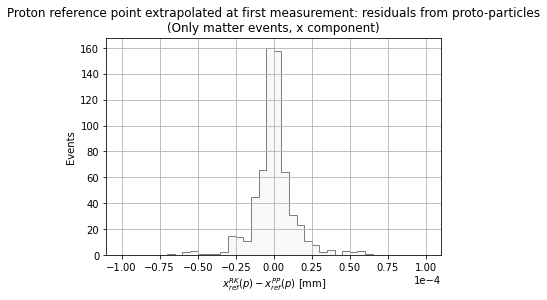

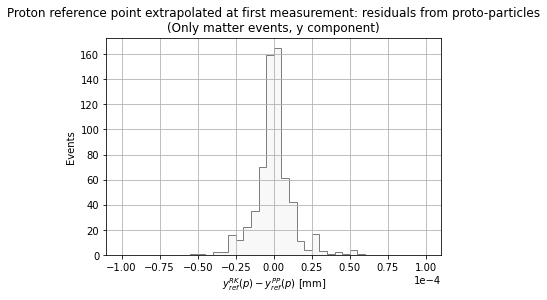

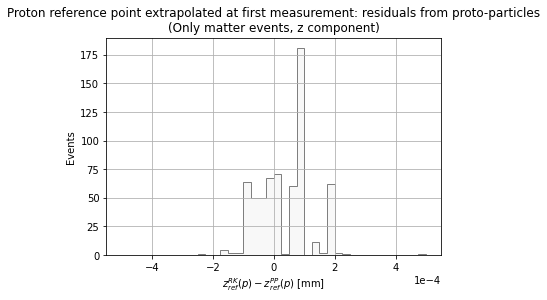

In [27]:
bias_boundary_dictionary = {
    'x': (-1e-4,1e-4),
    'y': (-1e-4,1e-4),
    'z': (-5e-4,5e-4)
}

for comp in ['x', 'y', 'z']:   
    rk_feature = 'p_AtFirstMeas_REFP_' + comp.upper()
    pp_feature = 'p_PP_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '_{ref}^{RK}(p) - ' + comp + '_{ref}^{PP}(p)$ [mm]',
        'plot_title': 'Proton reference point extrapolated at first measurement: residuals from proto-particles\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_AtFirstMeas_refpoint_PPres_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[rk_feature] - df_events[pp_feature],
        **plot_args)

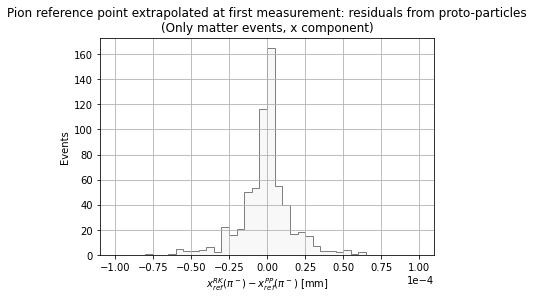

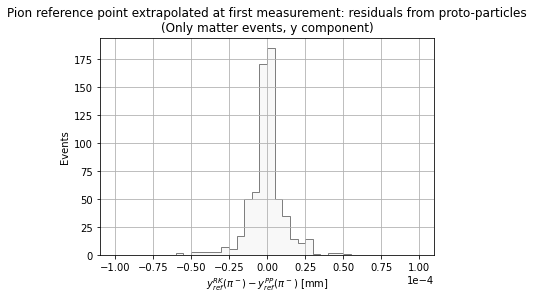

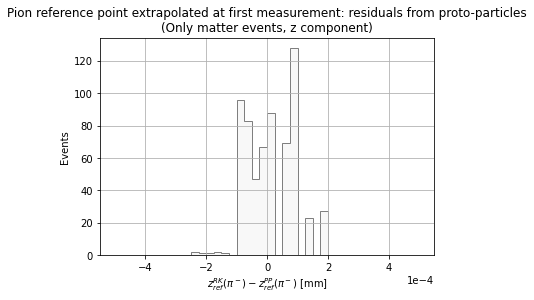

In [28]:
bias_boundary_dictionary = {
    'x': (-1e-4,1e-4),
    'y': (-1e-4,1e-4),
    'z': (-5e-4,5e-4)
}

for comp in ['x', 'y', 'z']:   
    rk_feature = 'pim_AtFirstMeas_REFP_' + comp.upper()
    pp_feature = 'pim_PP_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '_{ref}^{RK}(\pi^-) - ' + comp + '_{ref}^{PP}(\pi^-)$ [mm]',
        'plot_title': 'Pion reference point extrapolated at first measurement: residuals from proto-particles\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_AtFirstMeas_refpoint_PPres_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[rk_feature] - df_events[pp_feature],
        **plot_args)

Resolution is quite high on the reference point front. Now let's check the momenta, which are critical.

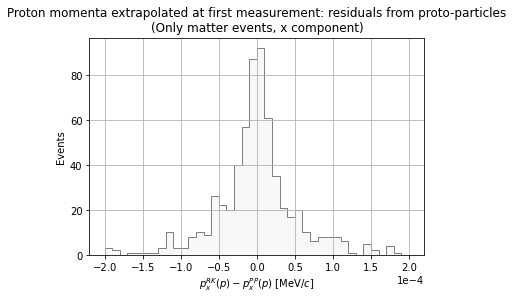

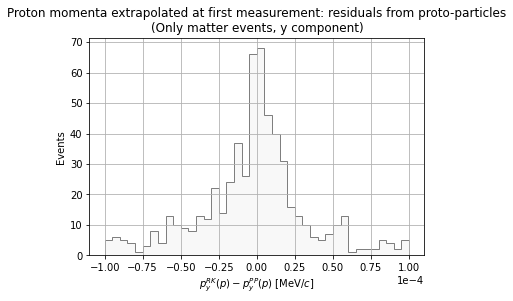

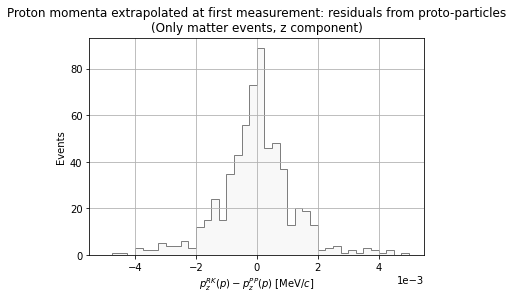

In [29]:
bias_boundary_dictionary = {
    'x': (-2e-4,2e-4),
    'y': (-1e-4,1e-4),
    'z': (-5e-3,5e-3)
}

for comp in ['x', 'y', 'z']:   
    rk_feature = 'p_AtFirstMeas_P_' + comp.upper()
    pp_feature = 'p_PP_P' + comp.upper()

    plot_args = {
        'axis_label': '$p_' + comp + '^{RK}(p) - p_' + comp + '^{PP}(p)$ [MeV/$c$]',
        'plot_title': 'Proton momenta extrapolated at first measurement: residuals from proto-particles\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_AtFirstMeas_momentum_PPres_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[rk_feature] - df_events[pp_feature],
        **plot_args)

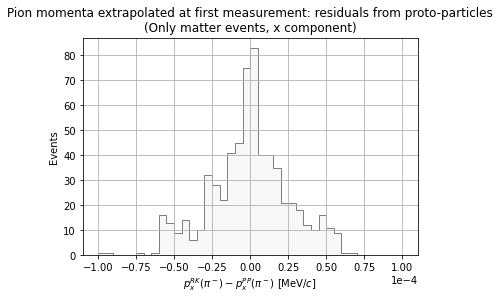

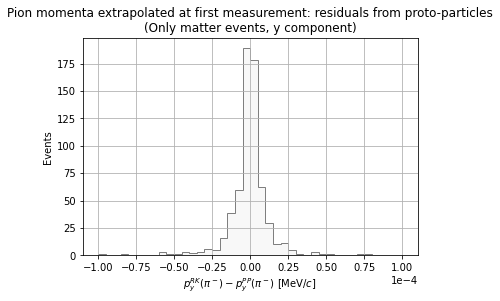

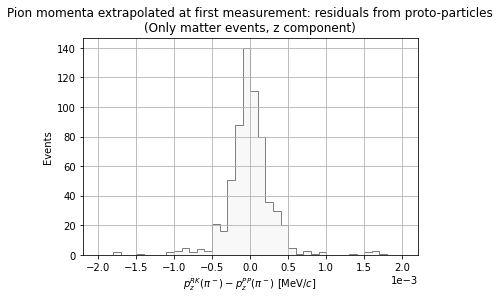

In [30]:
bias_boundary_dictionary = {
    'x': (-1e-4,1e-4),
    'y': (-1e-4,1e-4),
    'z': (-2e-3,2e-3)
}

for comp in ['x', 'y', 'z']:   
    rk_feature = 'pim_AtFirstMeas_P_' + comp.upper()
    pp_feature = 'pim_PP_P' + comp.upper()

    plot_args = {
        'axis_label': '$p_' + comp + '^{RK}(\pi^-) - p_' + comp + '^{PP}(\pi^-)$ [MeV/$c$]',
        'plot_title': 'Pion momenta extrapolated at first measurement: residuals from proto-particles\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_AtFirstMeas_momentum_PPres_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[rk_feature] - df_events[pp_feature],
        **plot_args)

Without going through the hassle of computing the relative residuals, a tolerance of some keV seems okay to me.
Extrapolating after fit back to the starting point yields basically the same results as the proto-particle saved before all this, therefore we can proceed with the juicy part.

# Reco vs. MC residual at first measurement